# Phase 1 – Extraction & Initial Profiling #

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

BASE_OUTPUT = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase1_extraction_simple")
BASE_OUTPUT.mkdir(parents=True, exist_ok=True)

print(f" All outputs will be saved to: {BASE_OUTPUT}\n")

# Step 1: Loading Datasets

heart_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\heart_disease_dataset.csv")
medical_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\Medicaldataset.csv")

if not heart_path.exists() or not medical_path.exists():
    raise FileNotFoundError(" One or both dataset files were not found. Please verify your file paths.")

heart = pd.read_csv(heart_path)
medical = pd.read_csv(medical_path)

# Step 2: Normalizing Column Names

def normalize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
        .str.strip('_')
    )
    return df

heart = normalize_columns(heart)
medical = normalize_columns(medical)


# Step 3: Basic Dataset Info

print(" Datasets Loaded Successfully\n")
print(f"Heart Dataset Shape: {heart.shape}")
print(f"Medical Dataset Shape: {medical.shape}\n")

# Check duplicates
print(f"Duplicate Rows in Heart Dataset: {heart.duplicated().sum()}")
print(f"Duplicate Rows in Medical Dataset: {medical.duplicated().sum()}\n")

# Step 4: Missing Values Overview
print(" Missing Values in Heart Dataset:")
missing_heart = heart.isnull().sum()[heart.isnull().sum() > 0]
print(missing_heart if not missing_heart.empty else "No missing values found.")

print("\n Missing Values in Medical Dataset:")
missing_medical = medical.isnull().sum()[medical.isnull().sum() > 0]
print(missing_medical if not missing_medical.empty else "No missing values found.")

# Step 5: Quick Statistics
print("\n Heart Dataset Summary Statistics:")
print(heart.describe())

print("\n Medical Dataset Summary Statistics:")
print(medical.describe())


heart.describe().to_csv(BASE_OUTPUT / "heart_summary_stats.csv")
medical.describe().to_csv(BASE_OUTPUT / "medical_summary_stats.csv")

heart.to_csv(BASE_OUTPUT / "heart_normalized.csv", index=False)
medical.to_csv(BASE_OUTPUT / "medical_normalized.csv", index=False)

print(f"\n Phase 1 Completed Successfully!")
print(f" Files saved in: {BASE_OUTPUT}")


try:
    os.startfile(BASE_OUTPUT)
except Exception as e:
    print(f"Note: Could not auto-open folder ({e}). Open manually at {BASE_OUTPUT}.")


 All outputs will be saved to: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase1_extraction_simple

 Datasets Loaded Successfully

Heart Dataset Shape: (1000, 16)
Medical Dataset Shape: (1319, 9)

Duplicate Rows in Heart Dataset: 0
Duplicate Rows in Medical Dataset: 0

 Missing Values in Heart Dataset:
alcohol_intake    340
dtype: int64

 Missing Values in Medical Dataset:
No missing values found.

 Heart Dataset Summary Statistics:
               age  cholesterol  blood_pressure   heart_rate  exercise_hours  \
count  1000.000000  1000.000000       1000.0000  1000.000000     1000.000000   
mean     52.293000   249.939000        135.2810    79.204000        4.529000   
std      15.727126    57.914673         26.3883    11.486092        2.934241   
min      25.000000   150.000000         90.0000    60.000000        0.000000   
25%      39.000000   200.000000        112.7500    70.000000        2.000000   
50%      52.000000   248.000000        136.0000    79.000000  

# Phase 2 – Part 1: Data Injection + Profiling Visualization #


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os


BASE_OUTPUT = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_before_cleaning")
BASE_OUTPUT.mkdir(parents=True, exist_ok=True)

print(f" All outputs will be saved to: {BASE_OUTPUT}\n")


heart_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase1_extraction_simple\heart_normalized.csv")
medical_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase1_extraction_simple\medical_normalized.csv")

if not heart_path.exists() or not medical_path.exists():
    raise FileNotFoundError(" One or both Phase 1 normalized datasets not found. Please verify the file paths.")

heart = pd.read_csv(heart_path)
medical = pd.read_csv(medical_path)

print(" Datasets loaded successfully.")
print(f"Heart shape: {heart.shape}, Medical shape: {medical.shape}\n")


# Simulating Missing & Invalid Data (Data Injection)

def inject_missing_values(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=["number"]).columns
    for col in num_cols:
        mask = np.random.rand(len(df)) < 0.10  # inject ~10% NaNs
        df.loc[mask, col] = np.nan
    return df

def inject_invalid_values(df):
    df = df.copy()
    for col in df.select_dtypes(include="object").columns:
        if df[col].notna().any():
            random_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
            df.loc[random_indices, col] = "INVALID"
    return df

heart_corrupted = inject_invalid_values(inject_missing_values(heart))
medical_corrupted = inject_invalid_values(inject_missing_values(medical))

print("\n Heart dataset after corruption (sample):")
print(heart_corrupted.head(10))

print("\n Medical dataset after corruption (sample):")
print(medical_corrupted.head(10))


def show_corrupted_rows(df, name):
    corrupted = df[
        df.isnull().any(axis=1) |
        df.apply(lambda x: x.astype(str).str.upper().eq("INVALID")).any(axis=1)
    ]
    print(f"\n Showing first 10 corrupted rows in {name}:")
    print(corrupted.head(10))

show_corrupted_rows(heart_corrupted, "Heart Dataset")
show_corrupted_rows(medical_corrupted, "Medical Dataset")

# Profiling Summary Table (Before Cleaning)
def profiling_summary(df, name="dataset"):
    summary = pd.DataFrame({
        "Column": df.columns,
        "Data Type": df.dtypes.astype(str),
        "Missing Values": df.isnull().sum().values,
        "Missing %": (df.isnull().mean().values * 100).round(2),
        "Unique Values": [df[col].nunique() for col in df.columns],
        "Example Values": [
            df[col].dropna().astype(str).unique()[:3] if df[col].notna().any() else []
            for col in df.columns
        ]
    })
    summary["Invalid Values"] = [
        (df[col].astype(str).str.upper() == "INVALID").sum() for col in df.columns
    ]

    print(f"\n Profiling Summary for {name} (Before Cleaning):\n")
    print(summary)
    return summary

heart_summary = profiling_summary(heart_corrupted, "Heart Dataset")
medical_summary = profiling_summary(medical_corrupted, "Medical Dataset")

heart_corrupted.to_csv(BASE_OUTPUT / "heart_dataset_corrupted.csv", index=False)
medical_corrupted.to_csv(BASE_OUTPUT / "medical_dataset_corrupted.csv", index=False)
heart_summary.to_csv(BASE_OUTPUT / "heart_profiling_before_cleaning.csv", index=False)
medical_summary.to_csv(BASE_OUTPUT / "medical_profiling_before_cleaning.csv", index=False)

print("\n💾 Corrupted datasets and profiling summaries saved successfully.")
print(f"📁 Files saved in: {BASE_OUTPUT}")


try:
    os.startfile(BASE_OUTPUT)
except Exception as e:
    print(f"Note: Could not auto-open folder ({e}). Open manually at {BASE_OUTPUT}.")


 All outputs will be saved to: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_before_cleaning

 Datasets loaded successfully.
Heart shape: (1000, 16), Medical shape: (1319, 9)


 Heart dataset after corruption (sample):
    age  gender  cholesterol  blood_pressure  heart_rate  smoking  \
0  75.0  Female        228.0           119.0        66.0  Current   
1  48.0    Male        204.0           165.0        62.0  Current   
2  53.0    Male        234.0            91.0         NaN  INVALID   
3  69.0  Female        192.0            90.0        72.0  Current   
4  62.0  Female        172.0             NaN        93.0    Never   
5  77.0    Male        309.0           110.0        73.0    Never   
6  64.0  Female        211.0           105.0        86.0   Former   
7  60.0  Female        208.0           148.0        83.0    Never   
8  37.0  Female        317.0           137.0        66.0  INVALID   
9  63.0    Male        204.0           141.0        68.0   Former 

 All outputs will be saved to: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_after_cleaning

 Corrupted datasets loaded.
Heart shape: (1000, 16), Medical shape: (1319, 9)


 Cleaning Heart Dataset...
No duplicates found.
Heart Dataset cleaned successfully. Final shape: (1000, 16)

 Cleaning Medical Dataset...
No duplicates found.
Medical Dataset cleaned successfully. Final shape: (1319, 9)

 Profiling Summary for Heart Dataset (After Cleaning):

                                          Column Data Type  Missing Values  \
age                                          age   float64               0   
gender                                    gender     int64               0   
cholesterol                          cholesterol   float64               0   
blood_pressure                    blood_pressure   float64               0   
heart_rate                            heart_rate   float64               0   
smoking                                  smoking     int6

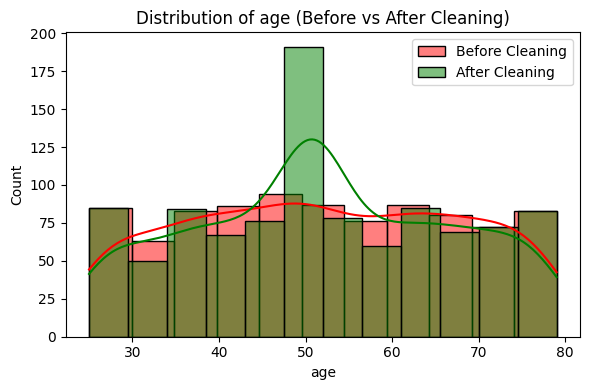


 Cleaned datasets and profiling tables saved successfully.
 Files saved in: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_after_cleaning


In [3]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

BASE_OUTPUT = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_after_cleaning")
BASE_OUTPUT.mkdir(parents=True, exist_ok=True)

print(f" All outputs will be saved to: {BASE_OUTPUT}\n")


heart_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_before_cleaning\heart_dataset_corrupted.csv")
medical_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_before_cleaning\medical_dataset_corrupted.csv")

if not heart_path.exists() or not medical_path.exists():
    raise FileNotFoundError(" One or both corrupted dataset files not found. Please verify the paths.")

heart = pd.read_csv(heart_path)
medical = pd.read_csv(medical_path)

print(" Corrupted datasets loaded.")
print(f"Heart shape: {heart.shape}, Medical shape: {medical.shape}\n")


# Step 2: Cleaning Function

def clean_dataset(df, name="dataset"):
    print(f"\n Cleaning {name}...")
    df = df.copy()

    # 2A. Convert "INVALID" → NaN
    df = df.replace(r"^\s*INVALID\s*$", np.nan, regex=True)

    # 2B. Identify numeric & categorical columns
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = df.select_dtypes(include="object").columns.tolist()

    # 2C. Clip outliers using IQR
    for col in num_cols:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)

    # 2D. Impute missing values
    num_imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")
    if num_cols:
        df[num_cols] = num_imputer.fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # 2E. Encode categorical columns
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # 2F. Remove duplicates
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        df = df.drop_duplicates()
        print(f"Removed {dup_count} duplicate rows.")
    else:
        print("No duplicates found.")

    print(f"{name} cleaned successfully. Final shape: {df.shape}")
    return df

#Clean now hehehe
heart_clean = clean_dataset(heart, "Heart Dataset")
medical_clean = clean_dataset(medical, "Medical Dataset")

# Profiling
def profiling_summary(df, name="dataset"):
    summary = pd.DataFrame({
        "Column": df.columns,
        "Data Type": df.dtypes.astype(str),
        "Missing Values": df.isnull().sum().values,
        "Missing %": (df.isnull().mean().values * 100).round(2),
        "Unique Values": [df[col].nunique() for col in df.columns],
        "Example Values": [
            df[col].dropna().astype(str).unique()[:3] if df[col].notna().any() else []
            for col in df.columns
        ]
    })
    print(f"\n Profiling Summary for {name} (After Cleaning):\n")
    print(summary)
    return summary

heart_summary_after = profiling_summary(heart_clean, "Heart Dataset")
medical_summary_after = profiling_summary(medical_clean, "Medical Dataset")


num_col = heart_clean.select_dtypes(include=["number"]).columns[0]

plt.figure(figsize=(6,4))
sns.histplot(heart[num_col], kde=True, color="red", label="Before Cleaning")
sns.histplot(heart_clean[num_col], kde=True, color="green", label="After Cleaning")
plt.title(f"Distribution of {num_col} (Before vs After Cleaning)")
plt.legend()
plt.tight_layout()
plt.show()


heart_clean.to_csv(BASE_OUTPUT / "heart_dataset_cleaned.csv", index=False)
medical_clean.to_csv(BASE_OUTPUT / "medical_dataset_cleaned.csv", index=False)
heart_summary_after.to_csv(BASE_OUTPUT / "heart_profiling_after_cleaning.csv", index=False)
medical_summary_after.to_csv(BASE_OUTPUT / "medical_profiling_after_cleaning.csv", index=False)

print("\n Cleaned datasets and profiling tables saved successfully.")
print(f" Files saved in: {BASE_OUTPUT}")


try:
    os.startfile(BASE_OUTPUT)
except Exception as e:
    print(f"Note: Could not auto-open folder ({e}). Open manually at {BASE_OUTPUT}.")



🧮 Missing Value Check (After Cleaning):
           Dataset  Total Missing Values
0    Heart Dataset                     0
1  Medical Dataset                     0

 Descriptive Statistics Comparison (Heart Dataset):
Before Cleaning:
              age  cholesterol  blood_pressure  heart_rate  exercise_hours  \
count  896.000000   906.000000      907.000000  915.000000      908.000000   
mean    52.026786   249.456954      135.005513   79.215301        4.512115   
std     15.674744    58.040154       26.507464   11.530029        2.942085   
min     25.000000   150.000000       90.000000   60.000000        0.000000   
25%     39.000000   200.000000      112.000000   70.000000        2.000000   
50%     51.000000   248.000000      135.000000   79.000000        4.000000   
75%     65.250000   298.000000      159.000000   89.000000        7.000000   
max     79.000000   349.000000      179.000000   99.000000        9.000000   

       stress_level  blood_sugar  heart_disease  
count    877.

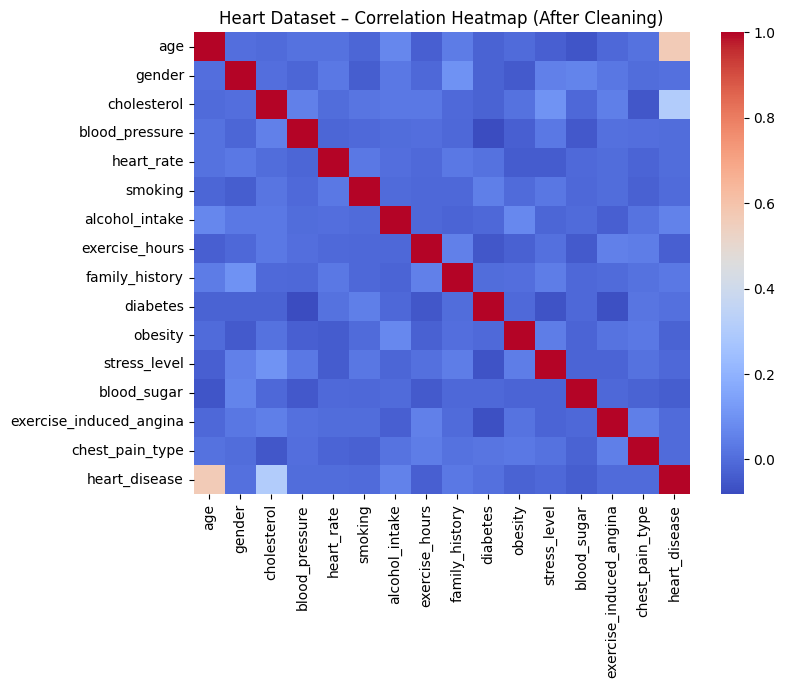

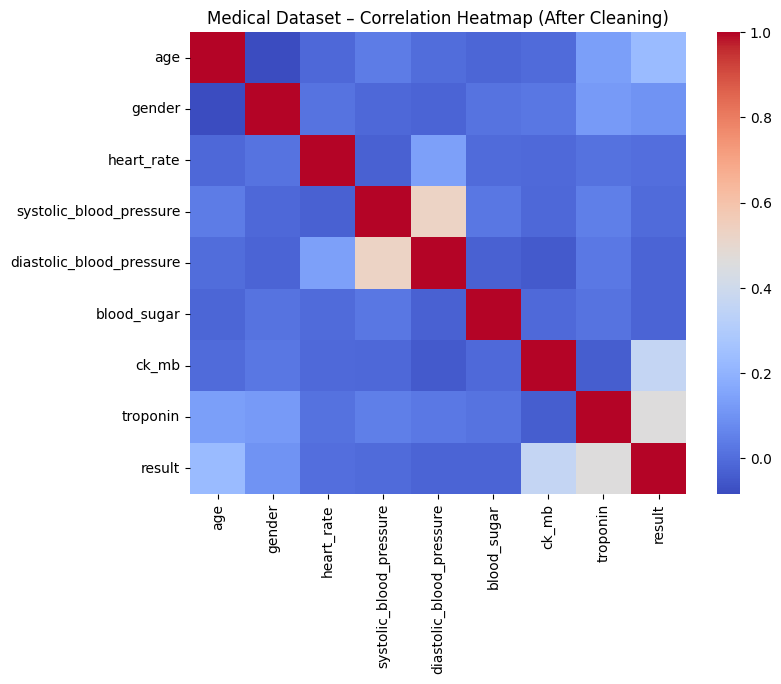


 Verification complete: No missing values remain, distributions normalized, and outliers reduced.


In [4]:

# Proof That Data Is Fully Cleaned

print("\n🧮 Missing Value Check (After Cleaning):")
missing_summary = pd.DataFrame({
    "Dataset": ["Heart Dataset", "Medical Dataset"],
    "Total Missing Values": [
        heart_clean.isnull().sum().sum(),
        medical_clean.isnull().sum().sum()
    ]
})
print(missing_summary)

# 1️ Descriptive Statistics Comparison
print("\n Descriptive Statistics Comparison (Heart Dataset):")
print("Before Cleaning:")
print(heart.describe())
print("\nAfter Cleaning:")
print(heart_clean.describe())

# 2️ Correlation Heatmap (After Cleaning)
plt.figure(figsize=(8,6))
sns.heatmap(heart_clean.corr(), cmap="coolwarm", annot=False)
plt.title("Heart Dataset – Correlation Heatmap (After Cleaning)")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(medical_clean.corr(), cmap="coolwarm", annot=False)
plt.title("Medical Dataset – Correlation Heatmap (After Cleaning)")
plt.show()



print("\n Verification complete: No missing values remain, distributions normalized, and outliers reduced.")


# *Phase 3* #

In [5]:
# Step 3.1: Feature Engineering

import pandas as pd
from pathlib import Path
import os


out_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering")
out_dir.mkdir(parents=True, exist_ok=True)

print(f" All outputs will be saved to: {out_dir}\n")


heart_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_after_cleaning\heart_dataset_cleaned.csv")
medical_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_after_cleaning\medical_dataset_cleaned.csv")

if not heart_path.exists() or not medical_path.exists():
    raise FileNotFoundError(" One or both cleaned dataset files not found. Please verify the paths.")

heart = pd.read_csv(heart_path)
medical = pd.read_csv(medical_path)

print(f" Datasets loaded successfully.\nHeart shape: {heart.shape}\nMedical shape: {medical.shape}\n")


heart_eng = heart.copy()
medical_eng = medical.copy()
engineered_cols = []



# 3A. BMI (requires weight & height)
if {"weight", "height"} <= set(medical_eng.columns):
    medical_eng["bmi"] = (medical_eng["weight"] / ((medical_eng["height"] / 100) ** 2)).round(2)
    engineered_cols.append(("medical", "bmi", "BMI calculated as weight / (height^2)"))

# 3B. Risk Score (cholesterol + blood_pressure / age)
if {"cholesterol", "blood_pressure", "age"} <= set(heart_eng.columns):
    heart_eng["risk_score"] = ((heart_eng["cholesterol"] + heart_eng["blood_pressure"]) / heart_eng["age"]).round(2)
    engineered_cols.append(("heart", "risk_score", "(cholesterol + blood_pressure) / age"))

# 3C. Lifestyle Score (smoking & alcohol)
# Lifestyle Score (from HEART dataset)
if {"smoking", "alcohol_intake"} <= set(heart_eng.columns):
    heart_eng["lifestyle_score"] = (
        heart_eng["smoking"] * 0.6 + heart_eng["alcohol_intake"] * 0.4
    ).round(2)
    engineered_cols.append(("heart", "lifestyle_score", "0.6*smoking + 0.4*alcohol_intake"))

# 3D. Age Group Buckets
if "age" in heart_eng.columns:
    heart_eng["age_group"] = pd.cut(
        heart_eng["age"],
        bins=[0, 30, 45, 60, 200],
        labels=["Young", "Middle-Aged", "Senior", "Elder"],
        include_lowest=True
    )
    engineered_cols.append(("heart", "age_group", "Age bucket categories"))


heart_new = [c for c in heart_eng.columns if c not in heart.columns]
medical_new = [c for c in medical_eng.columns if c not in medical.columns]

outcomes = pd.DataFrame(engineered_cols, columns=["Dataset", "New Column", "Definition"])
outcomes.to_csv(out_dir / "feature_engineering_outcomes.csv", index=False)

heart_sample = (
    heart_eng[heart_new + [c for c in ["age", "cholesterol", "blood_pressure"] if c in heart_eng.columns]]
    .head(10)
    if heart_new else pd.DataFrame()
)
medical_sample = (
    medical_eng[medical_new + [c for c in ["weight", "height", "smoking", "alcohol_intake"] if c in medical_eng.columns]]
    .head(10)
    if medical_new else pd.DataFrame()
)

if not heart_sample.empty:
    heart_sample.to_csv(out_dir / "heart_engineered_sample.csv", index=False)
if not medical_sample.empty:
    medical_sample.to_csv(out_dir / "medical_engineered_sample.csv", index=False)
#saving the files for my use lol
heart_eng.to_csv(out_dir / "heart_feature_engineered.csv", index=False)
medical_eng.to_csv(out_dir / "medical_feature_engineered.csv", index=False)


print("✅ Feature Engineering Completed Successfully.")
print(f"New Columns in HEART Dataset: {heart_new}")
print(f"New Columns in MEDICAL Dataset: {medical_new}")
print("\n📁 Files Saved:")
print(f"- {out_dir / 'feature_engineering_outcomes.csv'} (Table of new features + definitions)")
if not heart_sample.empty:
    print(f"- {out_dir / 'heart_engineered_sample.csv'} (10-row preview for report)")
if not medical_sample.empty:
    print(f"- {out_dir / 'medical_engineered_sample.csv'} (10-row preview for report)")
print(f"- {out_dir / 'heart_feature_engineered.csv'} (Full engineered heart dataset)")
print(f"- {out_dir / 'medical_feature_engineered.csv'} (Full engineered medical dataset)")


try:
    os.startfile(out_dir)
except Exception as e:
    print(f"Note: Could not auto-open folder ({e}). Open manually at {out_dir}.")


 All outputs will be saved to: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering

 Datasets loaded successfully.
Heart shape: (1000, 16)
Medical shape: (1319, 9)

✅ Feature Engineering Completed Successfully.
New Columns in HEART Dataset: ['risk_score', 'lifestyle_score', 'age_group']
New Columns in MEDICAL Dataset: []

📁 Files Saved:
- C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\feature_engineering_outcomes.csv (Table of new features + definitions)
- C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\heart_engineered_sample.csv (10-row preview for report)
- C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\heart_feature_engineered.csv (Full engineered heart dataset)
- C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\medical_feature_engineered.csv (Full engineered medical datase

In [17]:
# Show only engineered columns (first 10 rows)
engineered_cols = ["risk_score", "lifestyle_score", "age_group"]

heart_eng[engineered_cols].head(10)


,risk_score,lifestyle_score,age_group
0,4.63,0.0,Elder
1,7.69,0.0,Senior
2,6.13,0.0,Senior
3,4.09,0.0,Elder
4,4.95,1.2,Elder
5,5.44,1.2,Elder
6,4.94,0.6,Elder
7,5.93,1.6,Senior
8,12.27,0.0,Middle-Aged
9,5.48,0.6,Elder


In [6]:
print(medical.columns.tolist())


['age', 'gender', 'heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'blood_sugar', 'ck_mb', 'troponin', 'result']


 All outputs will be saved to: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_scaling

Heart shape: (1000, 19), Medical shape: (1319, 9)

Numeric columns in Heart: ['age', 'gender', 'cholesterol', 'blood_pressure', 'heart_rate', 'smoking', 'alcohol_intake', 'exercise_hours', 'family_history', 'diabetes', 'obesity', 'stress_level', 'blood_sugar', 'exercise_induced_angina', 'chest_pain_type', 'heart_disease', 'risk_score', 'lifestyle_score']
Numeric columns in Medical: ['age', 'gender', 'heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'blood_sugar', 'ck_mb', 'troponin', 'result']

 Scaling applied successfully!


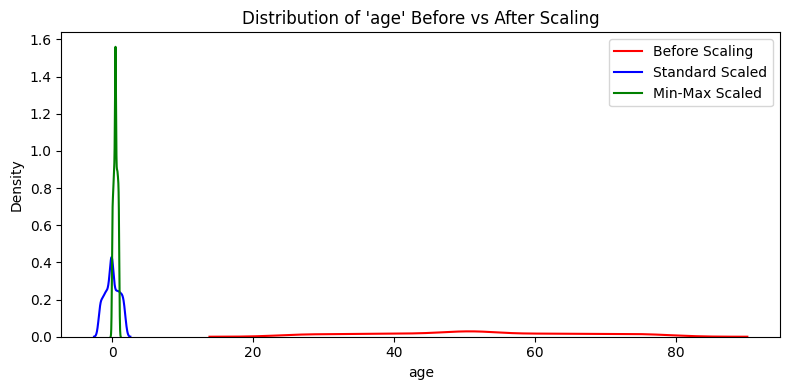


 Scaled datasets and comparison summary saved in: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_scaling


In [7]:
# Step 3.2: Feature Scaling (Standard + Min-Max)


import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os


out_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_scaling")
out_dir.mkdir(parents=True, exist_ok=True)

print(f" All outputs will be saved to: {out_dir}\n")

heart = pd.read_csv(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\heart_feature_engineered.csv")
medical = pd.read_csv(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\medical_feature_engineered.csv")

print(f"Heart shape: {heart.shape}, Medical shape: {medical.shape}")

#num columns
heart_num = heart.select_dtypes(include=["number"]).columns
medical_num = medical.select_dtypes(include=["number"]).columns

print(f"\nNumeric columns in Heart: {list(heart_num)}")
print(f"Numeric columns in Medical: {list(medical_num)}")

#scaling time lol
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()


heart_scaled_std = heart.copy()
heart_scaled_mm = heart.copy()
medical_scaled_std = medical.copy()
medical_scaled_mm = medical.copy()

heart_scaled_std[heart_num] = scaler_standard.fit_transform(heart[heart_num])
medical_scaled_std[medical_num] = scaler_standard.fit_transform(medical[medical_num])

heart_scaled_mm[heart_num] = scaler_minmax.fit_transform(heart[heart_num])
medical_scaled_mm[medical_num] = scaler_minmax.fit_transform(medical[medical_num])

print("\n Scaling applied successfully!")


col = heart_num[0]
plt.figure(figsize=(8,4))
sns.kdeplot(heart[col], color="red", label="Before Scaling")
sns.kdeplot(heart_scaled_std[col], color="blue", label="Standard Scaled")
sns.kdeplot(heart_scaled_mm[col], color="green", label="Min-Max Scaled")
plt.legend()
plt.title(f"Distribution of '{col}' Before vs After Scaling")
plt.tight_layout()
plt.show()

heart_scaled_std.to_csv(out_dir / "heart_scaled_standard.csv", index=False)
heart_scaled_mm.to_csv(out_dir / "heart_scaled_minmax.csv", index=False)
medical_scaled_std.to_csv(out_dir / "medical_scaled_standard.csv", index=False)
medical_scaled_mm.to_csv(out_dir / "medical_scaled_minmax.csv", index=False)


comparison = pd.DataFrame({
    "Dataset": ["Heart", "Heart", "Medical", "Medical"],
    "Scaling Type": ["Standard", "Min-Max", "Standard", "Min-Max"],
    "Rows": [len(heart)] * 2 + [len(medical)] * 2,
    "Columns": [len(heart.columns)] * 2 + [len(medical.columns)] * 2
})
comparison.to_csv(out_dir / "scaling_comparison_summary.csv", index=False)

print(f"\n Scaled datasets and comparison summary saved in: {out_dir}")


try:
    os.startfile(out_dir)
except Exception as e:
    print(f"Note: Could not auto-open folder ({e}). Open manually at {out_dir}.")


In [8]:
#  Step 3.3: Integration using age + gender


import pandas as pd
from pathlib import Path
import os

# Paths
heart_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\heart_feature_engineered.csv")
medical_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_feature_engineering\medical_feature_engineered.csv")
out_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration")
out_dir.mkdir(parents=True, exist_ok=True)

# Load
heart = pd.read_csv(heart_path)
medical = pd.read_csv(medical_path)

# Merge on demographic keys
merge_keys = ['age', 'gender']
merged = pd.merge(heart, medical, on=merge_keys, how='inner')

print(f" Merged successfully on keys: {merge_keys}")
print(f"Final merged shape: {merged.shape}")

# Saving
merged.to_csv(out_dir / "integrated_dataset.csv", index=False)


summary = pd.DataFrame({
    "Rows": [merged.shape[0]],
    "Columns": [merged.shape[1]],
    "Merge Keys": [', '.join(merge_keys)]
})
summary.to_csv(out_dir / "integration_summary.csv", index=False)

print(f"\n Files saved in: {out_dir}")
print("Sample of merged dataset:")
print(merged.head(10))

try:
    os.startfile(out_dir)
except Exception as e:
    print(f"Note: Could not auto-open folder ({e}).")


 Merged successfully on keys: ['age', 'gender']
Final merged shape: (11002, 26)

 Files saved in: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration
Sample of merged dataset:
    age  gender  cholesterol  blood_pressure  heart_rate_x  smoking  \
0  75.0       0        228.0           119.0          66.0        0   
1  75.0       0        228.0           119.0          66.0        0   
2  75.0       0        228.0           119.0          66.0        0   
3  75.0       0        228.0           119.0          66.0        0   
4  75.0       0        228.0           119.0          66.0        0   
5  75.0       0        228.0           119.0          66.0        0   
6  75.0       0        228.0           119.0          66.0        0   
7  75.0       0        228.0           119.0          66.0        0   
8  75.0       0        228.0           119.0          66.0        0   
9  75.0       0        228.0           119.0          66.0        0   

   alcohol_

In [9]:
print(set(heart.columns) & set(medical.columns))


{'gender', 'age', 'blood_sugar', 'heart_rate'}


In [10]:
import pandas as pd

df = pd.read_csv(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration\integrated_dataset_cleaned.csv")
print(df.columns)


Index(['age', 'gender', 'cholesterol', 'blood_pressure', 'heart_rate_heart',
       'smoking', 'alcohol_intake', 'exercise_hours', 'family_history',
       'diabetes', 'obesity', 'stress_level', 'blood_sugar_heart',
       'exercise_induced_angina', 'chest_pain_type', 'heart_disease',
       'risk_score', 'age_group', 'heart_rate_medical',
       'systolic_blood_pressure', 'diastolic_blood_pressure',
       'blood_sugar_medical', 'ck_mb', 'troponin', 'result'],
      dtype='object')


# Data Visualizations

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

df = pd.read_csv(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration\integrated_dataset.csv")

viz_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase4_visualizations")
viz_dir.mkdir(parents=True, exist_ok=True)

print("Folder ready:", viz_dir)


Folder ready: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase4_visualizations


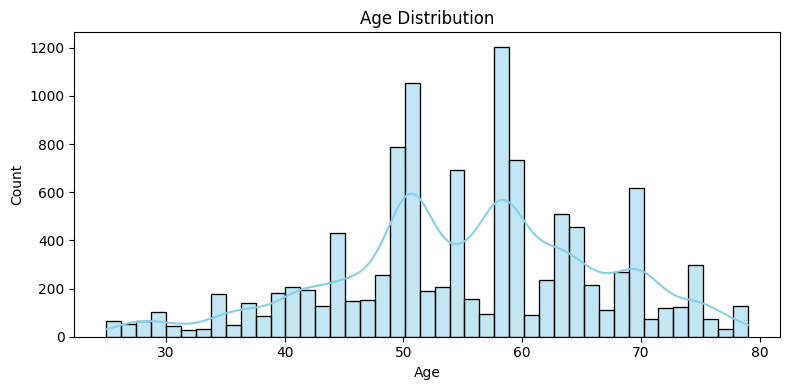

In [19]:
plt.figure(figsize=(8,4))
sns.histplot(df['age'], kde=True, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(viz_dir / "age_distribution.png")
plt.show()


C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\955163523.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['gender'], palette="viridis")


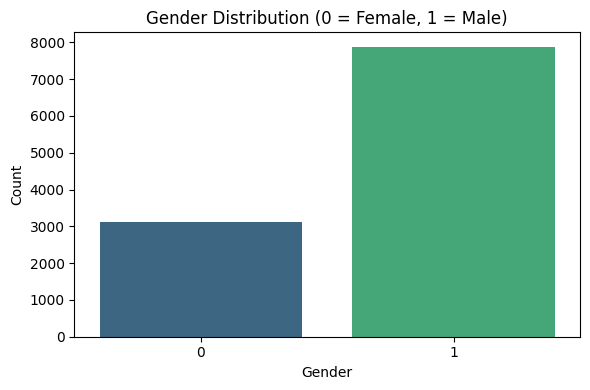

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['gender'], palette="viridis")
plt.title("Gender Distribution (0 = Female, 1 = Male)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(viz_dir / "gender_distribution.png")
plt.show()


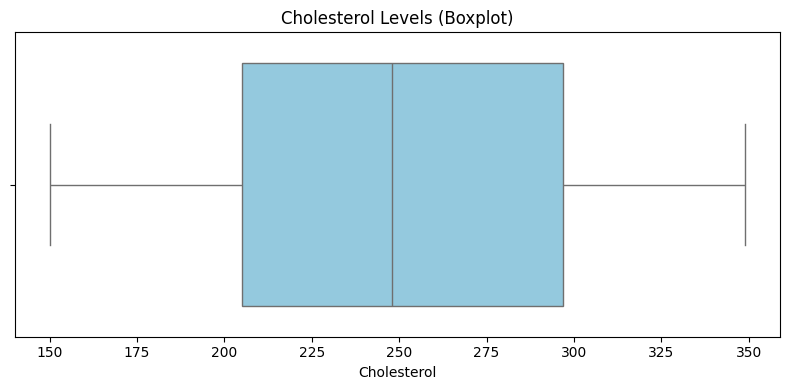

In [23]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['cholesterol'], color='skyblue')
plt.title("Cholesterol Levels (Boxplot)")
plt.xlabel("Cholesterol")
plt.tight_layout()
plt.savefig(viz_dir / "cholesterol_boxplot.png")
plt.show()


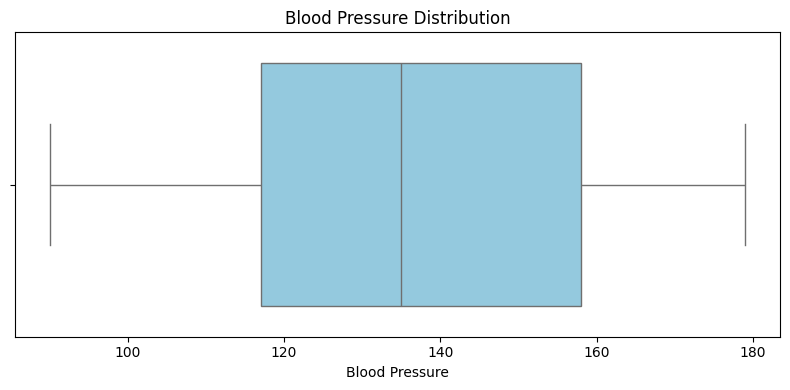

In [24]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['blood_pressure'], color='skyblue')
plt.title("Blood Pressure Distribution")
plt.xlabel("Blood Pressure")
plt.tight_layout()
plt.savefig(viz_dir / "blood_pressure_boxplot.png")
plt.show()


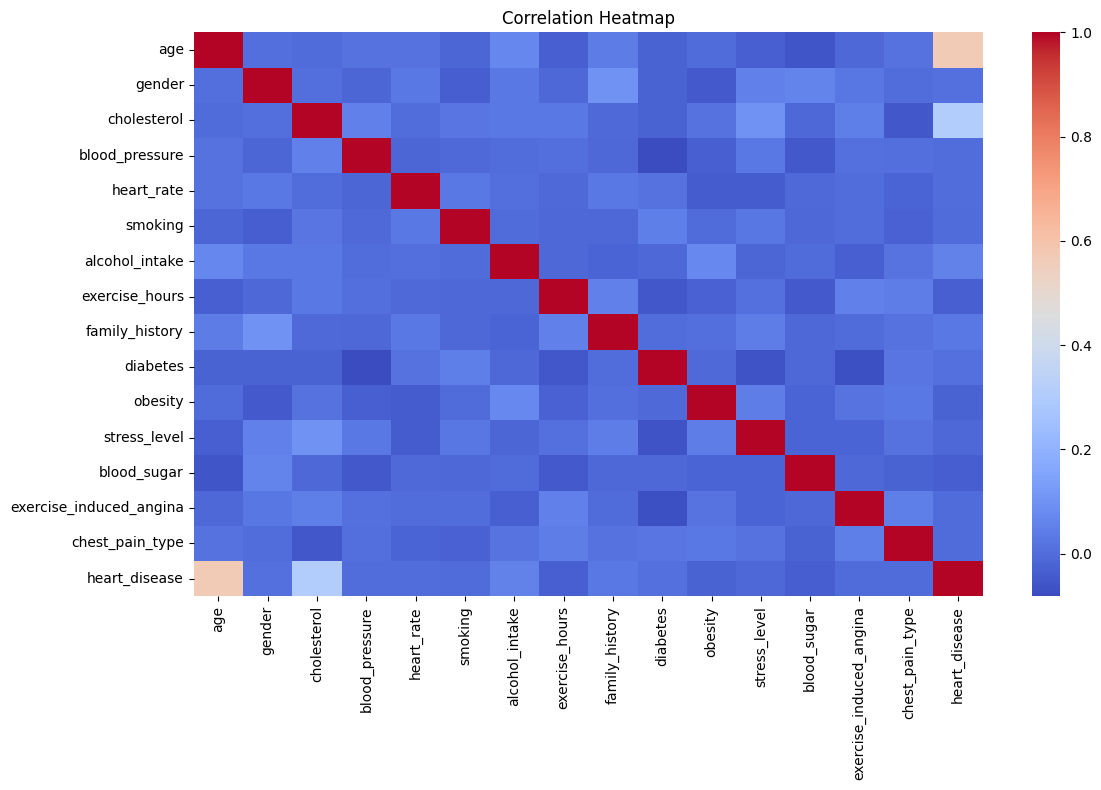

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Create the output directory
viz_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_visualizations")
viz_dir.mkdir(parents=True, exist_ok=True)

# Load your dataset (replace with your actual dataset)
df = pd.read_csv(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase2_after_cleaning\heart_dataset_cleaned.csv")

# Plot Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()

# Save the figure and display it
plt.savefig(viz_dir / "correlation_heatmap.png")
plt.show()


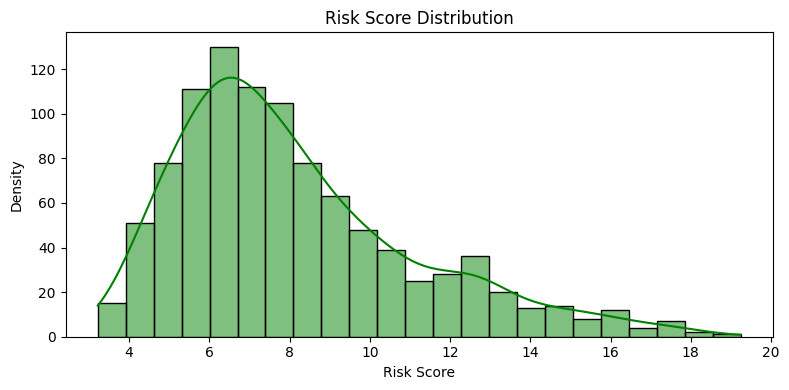

In [ ]:
if {"cholesterol", "blood_pressure", "age"} <= set(df.columns):
    df["risk_score"] = ((df["cholesterol"] + df["blood_pressure"]) / df["age"]).round(2)

plt.figure(figsize=(8,4))
sns.histplot(df['risk_score'], kde=True, color='green')
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


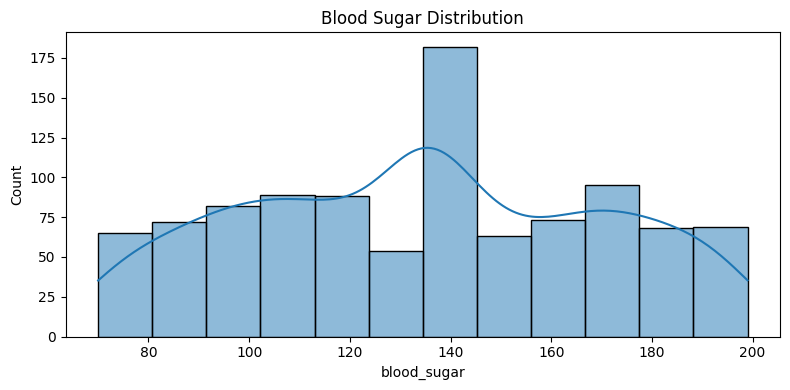

In [42]:
medical_columns = ['blood_sugar', 'ck_mb', 'troponin']

for col in medical_columns:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col], kde=True)
        plt.title(f"{col.replace('_',' ').title()} Distribution")
        plt.xlabel(col)
        plt.tight_layout()
        plt.savefig(viz_dir / f"{col}_distribution.png")
        plt.show()


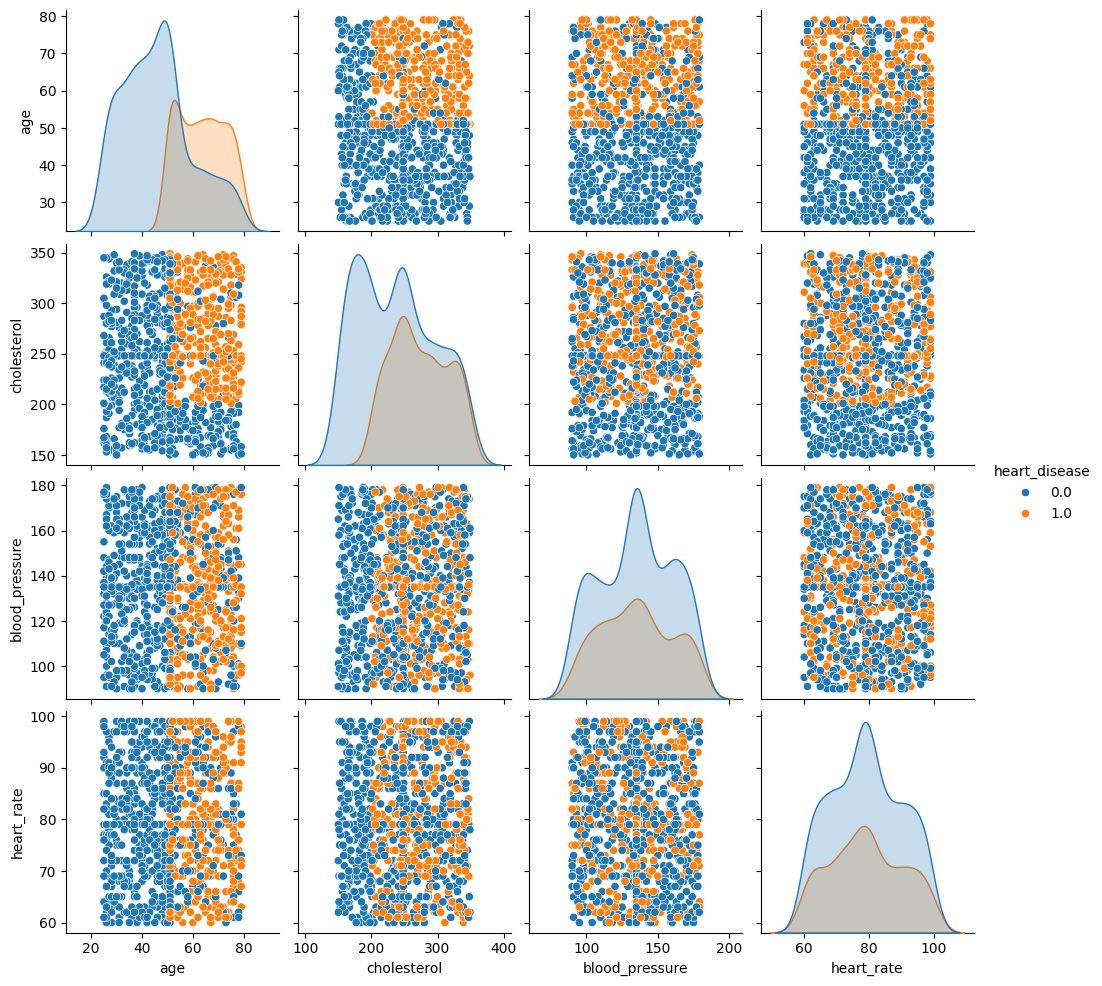

In [43]:
sample_cols = ['age', 'cholesterol', 'blood_pressure', 'heart_rate', 'heart_disease']

sns.pairplot(df[sample_cols], hue="heart_disease", diag_kind="kde")
plt.savefig(viz_dir / "pairplot_heart.png")
plt.show()


# *Phase 4* #

✅ Dataset loaded: (10383, 25)
 Correlation heatmap and correlation table saved!

 Train-Test split complete.
Train shape: (7787, 22), Test shape: (2596, 22)


C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\771263363.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances.head(15), palette="viridis")


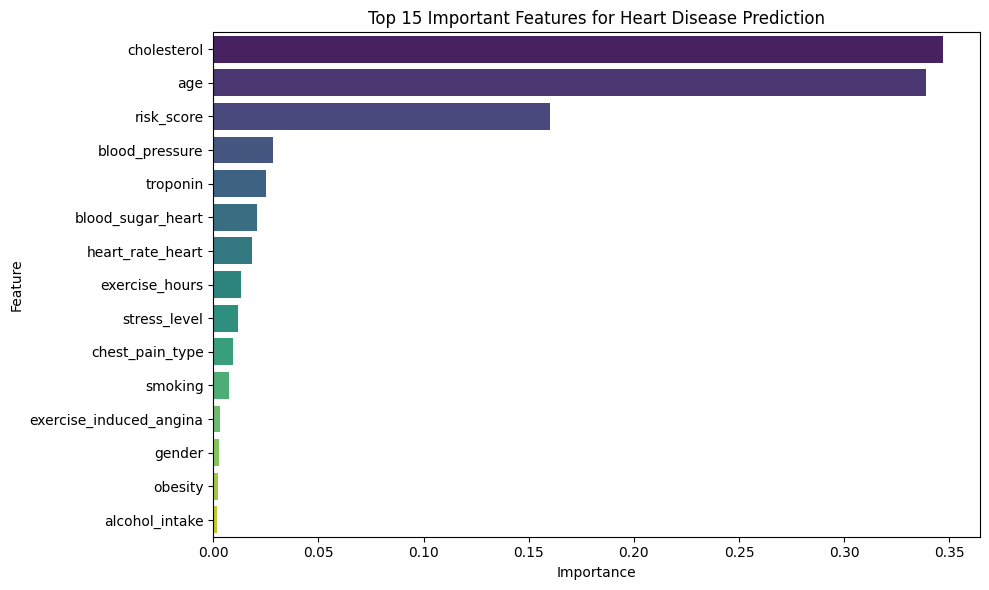


🧾 Model Evaluation Report:
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      1384
         1.0       0.87      1.00      0.93      1212

    accuracy                           0.93      2596
   macro avg       0.93      0.93      0.93      2596
weighted avg       0.94      0.93      0.93      2596


 Phase 4 completed successfully! Results saved in:
C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase4_feature_selection_fixed


In [ ]:
#Feature Selection & Correlation Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from pathlib import Path

data_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration\integrated_dataset_cleaned.csv")
df = pd.read_csv(data_path)
print(f" Dataset loaded: {df.shape}")


target_col = "heart_disease"
drop_cols = ["result", "age_group"]  
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Encode target if it's categorical
if df[target_col].dtype == "object":
    df[target_col] = LabelEncoder().fit_transform(df[target_col])


#  Correlation Analysis

numeric_df = df.select_dtypes(include=["number"])
corr = numeric_df.corr()

out_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase4_feature_selection_fixed")
out_dir.mkdir(parents=True, exist_ok=True)

corr[target_col].sort_values(ascending=False).to_csv(out_dir / "correlation_with_target.csv")

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap - Heart Disease Dataset")
plt.tight_layout()
plt.savefig(out_dir / "correlation_heatmap.png", dpi=300)
plt.close()

print(" Correlation heatmap and correlation table saved!")

# Train-Test Split 
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("\n Train-Test split complete.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Feature Importance 
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=6,         
    min_samples_split=5,
    random_state=42
)
rf.fit(X_train, y_train)

importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances.to_csv(out_dir / "feature_importance.csv", index=False)


#Visualization

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importances.head(15), palette="viridis")
plt.title("Top 15 Important Features for Heart Disease Prediction")
plt.tight_layout()
plt.savefig(out_dir / "feature_importance_chart.png", dpi=300)
plt.show()

# Step 7: Model Evaluation

y_pred = rf.predict(X_test)
print("\n🧾 Model Evaluation Report:")
print(classification_report(y_test, y_pred))

pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.to_csv(
    out_dir / "classification_report.csv"
)

print(f"\n Phase 4 completed successfully! Results saved in:\n{out_dir}")



In [45]:

numeric_df = df.select_dtypes(include=["number"])
corr = numeric_df.corr()

out_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase4_feature_selection_fixed")
out_dir.mkdir(parents=True, exist_ok=True)

corr[target_col].sort_values(ascending=False).to_csv(out_dir / "correlation_with_target.csv")

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap - Heart Disease Dataset")
plt.tight_layout()
plt.savefig(out_dir / "correlation_heatmap.png", dpi=300)
plt.close()

print(" Correlation heatmap and correlation table saved!")


 Correlation heatmap and correlation table saved!


In [12]:
import pandas as pd

df = pd.read_csv(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration\integrated_dataset_cleaned.csv")
corr = df.corr(numeric_only=True)['heart_disease'].sort_values(ascending=False)
print(corr.head(10))


heart_disease              1.000000
age                        0.468522
cholesterol                0.402581
result                     0.105415
smoking                    0.065112
troponin                   0.064808
blood_pressure             0.052086
exercise_induced_angina    0.047932
alcohol_intake             0.033651
blood_sugar_medical        0.032050
Name: heart_disease, dtype: float64


# *Phase 5* #

Top 10 Important Features:
              Feature  Importance
0        cholesterol    0.347189
1                age    0.338862
2         risk_score    0.159863
3     blood_pressure    0.028483
4           troponin    0.025201
5  blood_sugar_heart    0.020693
6   heart_rate_heart    0.018549
7     exercise_hours    0.013032
8       stress_level    0.011857
9    chest_pain_type    0.009383


C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\3914678698.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_features, palette="magma")


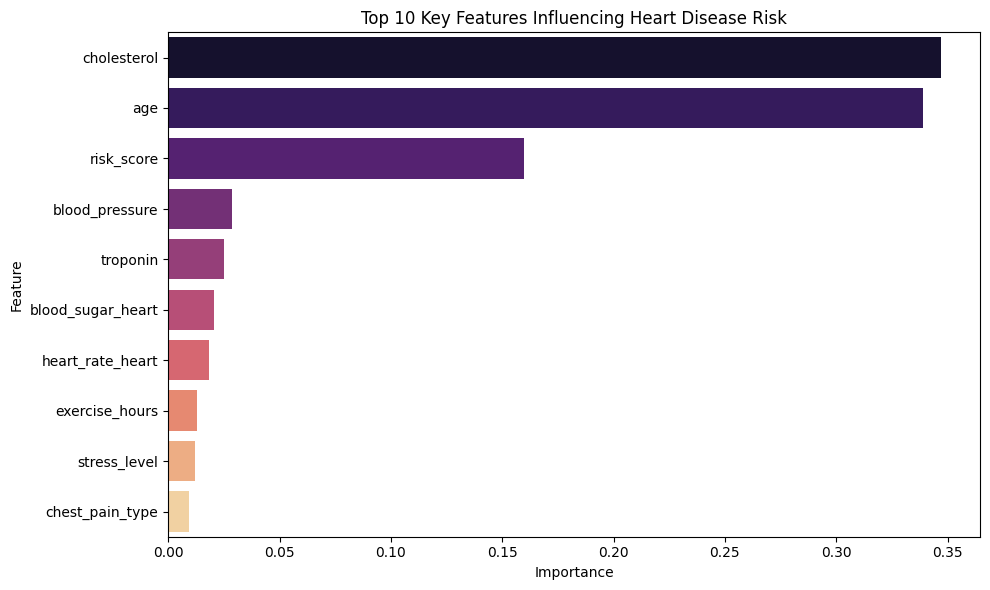

In [13]:
# Feature Interpretation & Insights

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


feature_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase4_feature_selection_fixed\feature_importance.csv")
importances = pd.read_csv(feature_path)

# Get Top 10
top_features = importances.head(10)
print("Top 10 Important Features:\n", top_features)


# Visualize Top Features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=top_features, palette="magma")
plt.title("Top 10 Key Features Influencing Heart Disease Risk")
plt.tight_layout()
plt.savefig(feature_path.parent / "top10_feature_insights.png", dpi=300)
plt.show()


# *Phase 6* #

 Dataset loaded successfully: (10383, 23)
Features used: 22
Target column: heart_disease

Dataset preview:
     age  gender  cholesterol  blood_pressure  heart_rate_heart  smoking  \
0  75.0       0        228.0           137.0              66.0        0   
1  75.0       0        228.0           137.0              66.0        0   
2  75.0       0        228.0           137.0              66.0        0   
3  75.0       0        228.0           137.0              66.0        0   
4  75.0       0        228.0           137.0              66.0        0   

   alcohol_intake  exercise_hours  family_history  diabetes  ...  \
0               0             1.0               0         0  ...   
1               0             1.0               0         0  ...   
2               0             1.0               0         0  ...   
3               0             1.0               0         0  ...   
4               0             1.0               0         0  ...   

   exercise_induced_angina  ches

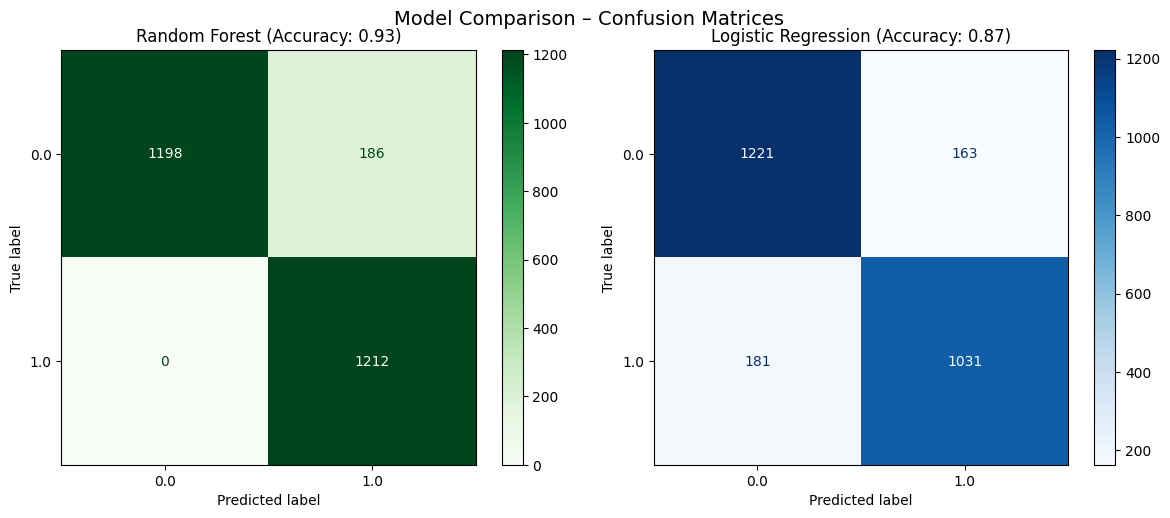

C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\3197025231.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=model_acc, palette="viridis")


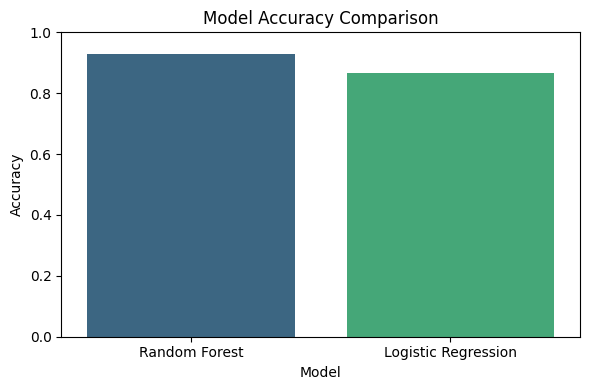

C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\3197025231.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="RF Importance", y="Feature", data=top_rf, palette="mako")
C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\3197025231.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="LR Coefficient", y="Feature", data=top_lr, palette="flare")


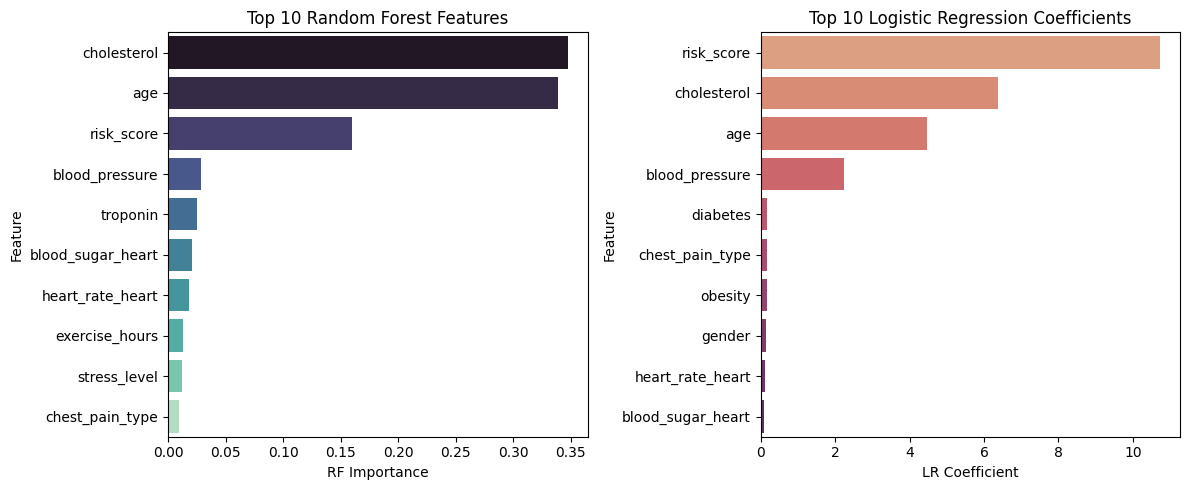


 All visualizations and reports saved in:
C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase6_model_comparison


In [14]:
#  Model Comparison, Visualization & Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)


data_path = Path(
    r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration\integrated_dataset_cleaned.csv"
)
df = pd.read_csv(data_path)

target_col = "heart_disease"
drop_cols = ["result", "age_group"]

# Drop irrelevant or weak columns
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Encode target if it's not numeric
if df[target_col].dtype == "object":
    df[target_col] = LabelEncoder().fit_transform(df[target_col])

# Encode categorical predictors
X = df.drop(columns=[target_col])
y = df[target_col]
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale data (for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Dataset loaded successfully: {df.shape}")
print(f"Features used: {X.shape[1]}")
print("Target column:", target_col)
print("\nDataset preview:\n", df.head())

# Train Models

rf = RandomForestClassifier(
    n_estimators=150, max_depth=6, min_samples_split=5, random_state=42
)
rf.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test_scaled)

# Evaluate Models

rf_acc = accuracy_score(y_test, rf_pred)
lr_acc = accuracy_score(y_test, lr_pred)

print("\n Model Accuracies:")
print(f"Random Forest Accuracy: {rf_acc:.3f}")
print(f"Logistic Regression Accuracy: {lr_acc:.3f}")

print("\n Random Forest Report:\n", classification_report(y_test, rf_pred))
print("\n Logistic Regression Report:\n", classification_report(y_test, lr_pred))


out_dir = Path(
    r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase6_model_comparison"
)
out_dir.mkdir(parents=True, exist_ok=True)


plt.figure(figsize=(12, 5))
plt.suptitle("Model Comparison – Confusion Matrices", fontsize=14)

plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Greens", ax=plt.gca())
plt.title(f"Random Forest (Accuracy: {rf_acc:.2f})")

plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(
    lr, X_test_scaled, y_test, cmap="Blues", ax=plt.gca()
)
plt.title(f"Logistic Regression (Accuracy: {lr_acc:.2f})")

plt.tight_layout()
plt.savefig(out_dir / "confusion_matrices_comparison.png", dpi=300)
plt.show()

# Accuracy Comparison Bar Chart
model_acc = pd.DataFrame(
    {"Model": ["Random Forest", "Logistic Regression"], "Accuracy": [rf_acc, lr_acc]}
)

plt.figure(figsize=(6, 4))
sns.barplot(x="Model", y="Accuracy", data=model_acc, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(out_dir / "accuracy_comparison_chart.png", dpi=300)
plt.show()

# Feature Importance vs Logistic Coefficients
rf_importance = pd.DataFrame(
    {"Feature": X.columns, "RF Importance": rf.feature_importances_}
).sort_values(by="RF Importance", ascending=False)

lr_coef = pd.DataFrame(
    {"Feature": X.columns, "LR Coefficient": abs(lr.coef_[0])}
).sort_values(by="LR Coefficient", ascending=False)

top_rf = rf_importance.head(10)
top_lr = lr_coef.head(10)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="RF Importance", y="Feature", data=top_rf, palette="mako")
plt.title("Top 10 Random Forest Features")

plt.subplot(1, 2, 2)
sns.barplot(x="LR Coefficient", y="Feature", data=top_lr, palette="flare")
plt.title("Top 10 Logistic Regression Coefficients")

plt.tight_layout()
plt.savefig(out_dir / "feature_comparison_chart.png", dpi=300)
plt.show()


model_acc.to_csv(out_dir / "model_comparison_summary.csv", index=False)
pd.DataFrame(classification_report(y_test, rf_pred, output_dict=True)).T.to_csv(
    out_dir / "rf_classification_report.csv"
)
pd.DataFrame(classification_report(y_test, lr_pred, output_dict=True)).T.to_csv(
    out_dir / "lr_classification_report.csv"
)

print(f"\n All visualizations and reports saved in:\n{out_dir}")


# *Phase 7* #

 Final Model Accuracy: 0.928
 ROC-AUC Score: 0.993

 Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.86      0.93      1384
         1.0       0.87      1.00      0.93      1212

    accuracy                           0.93      2596
   macro avg       0.93      0.93      0.93      2596
weighted avg       0.94      0.93      0.93      2596



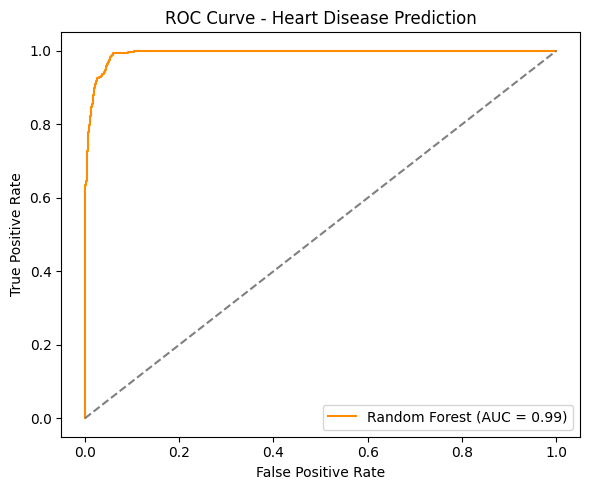

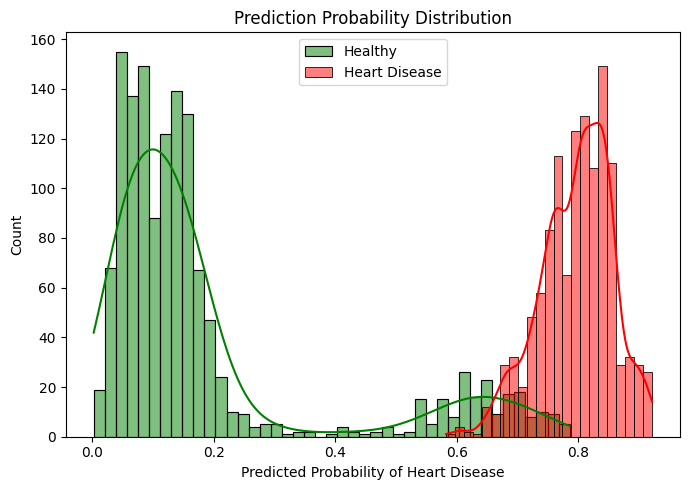

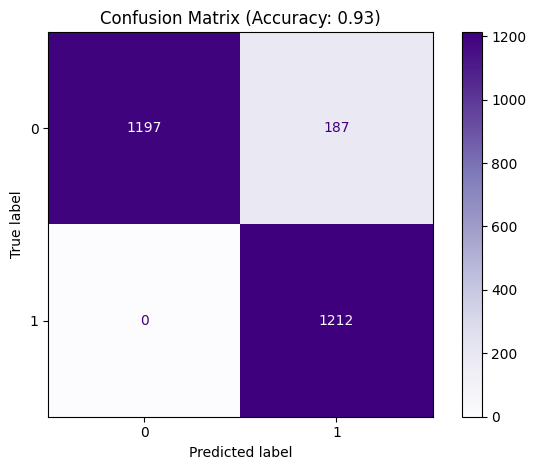

C:\Users\ranaz\AppData\Local\Temp\ipykernel_32200\3480926010.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Outcome", data=pred_df, palette="coolwarm")


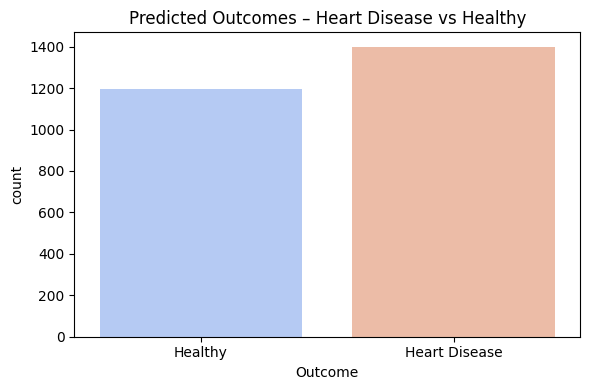


 All visualizations saved to: C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase7_visual_dashboard


In [15]:
#  Predictive Visualization & Results Dashboard

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)


data_path = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase3_integration\integrated_dataset_cleaned.csv")
df = pd.read_csv(data_path)

target_col = "heart_disease"
drop_cols = ["result", "age_group"]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])

if df[target_col].dtype == "object":
    df[target_col] = LabelEncoder().fit_transform(df[target_col])

X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical columns
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


rf = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f" Final Model Accuracy: {acc:.3f}")
print(f" ROC-AUC Score: {auc:.3f}")
print("\n Classification Report:\n", classification_report(y_test, y_pred))


out_dir = Path(r"C:\Users\ranaz\Desktop\Data Engineering proj\DataProjectOutputs\phase7_visual_dashboard")
out_dir.mkdir(parents=True, exist_ok=True)

# ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Heart Disease Prediction")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / "roc_curve.png", dpi=300)
plt.show()

# Prediction Probability Distribution

plt.figure(figsize=(7, 5))
sns.histplot(y_prob[y_test == 0], color="green", kde=True, label="Healthy")
sns.histplot(y_prob[y_test == 1], color="red", kde=True, label="Heart Disease")
plt.title("Prediction Probability Distribution")
plt.xlabel("Predicted Probability of Heart Disease")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / "probability_distribution.png", dpi=300)
plt.show()

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Purples")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2f})")
plt.tight_layout()
plt.savefig(out_dir / "confusion_matrix_final.png", dpi=300)
plt.show()

#  Predicted Outcome Comparison

pred_df = pd.DataFrame({"True Label": y_test, "Predicted": y_pred})
pred_df["Outcome"] = np.where(pred_df["Predicted"] == 1, "Heart Disease", "Healthy")

plt.figure(figsize=(6, 4))
sns.countplot(x="Outcome", data=pred_df, palette="coolwarm")
plt.title("Predicted Outcomes – Heart Disease vs Healthy")
plt.tight_layout()
plt.savefig(out_dir / "predicted_outcomes.png", dpi=300)
plt.show()

print(f"\n All visualizations saved to: {out_dir}")
